In [1]:
from pyscal.core import System
from pyscal.crystal_structures import Structure
from pyscal_rdf.json_io import write_file
from pyscal_rdf.rdfutils import convert_to_dict
from pyscal_rdf.visualize import visualize_graph
from pyscal_rdf.graph import StructureGraph

Update hedgedoc [here](https://iffmd.fz-juelich.de/BRIkKGLlQduS8dA0sXKoZw)

## Creating structure from pyscal

In [2]:
struct = Structure()

In [3]:
sys = struct.lattice.l12(element=['Al', 'Ni'], 
                         lattice_constant=3.57)

['Al', 'Ni']


In [4]:
sysdict = convert_to_dict(sys)

In [5]:
write_file("structure", sysdict)

In [6]:
g = StructureGraph(sysdict)
g.create_graph(names=True)

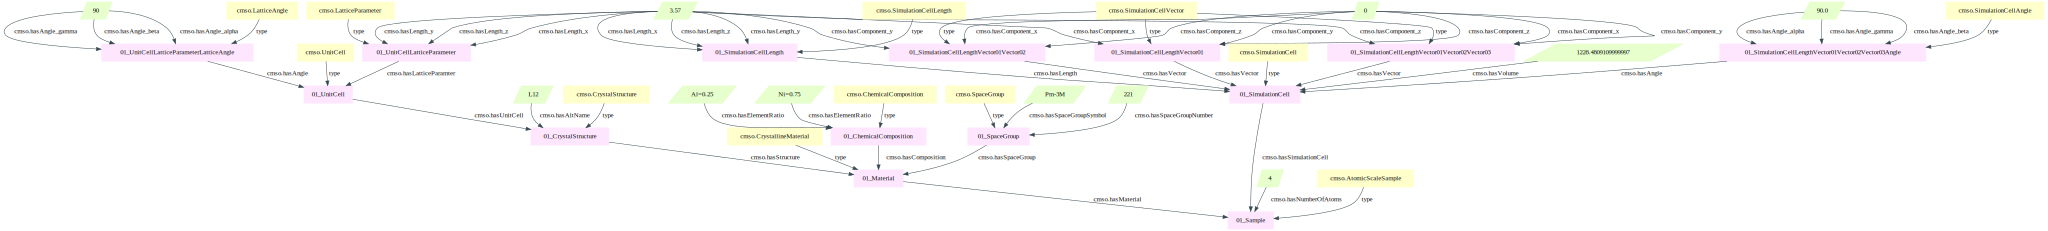

In [7]:
g.visualise()

We use `BNode` for the moment, is it really the best option? Please check

- Control decimal points
- Add references
- Plot: add fig size
- Plot: add font size
- Plot: add duplicate labels
- Dont hardcode lattice angles

`DCTERMS.http://purl.org/dc/terms/bibliographicCitation`